In [1]:
import numpy as np
import cv2
import os
import csv
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
def data_preprocessing(negative_pics, positive_pics):
    # Class 0 => No cracks 
    # Class 1 => Cracks 

    # Before reshape => (20000, 227, 227)
    # Want => (20000, 51529, 1)
    negative_images = []

    # Iterate over the folder with no cracks  
    for picture in os.scandir(negative_pics):
        if picture.is_file():
            pic_path = negative_pics + '/' + picture.name
            image = cv2.imread(pic_path)
            # Remove 3 channels 
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Each image is (227, 227, 3)
            # Grayscale => (227, 227, 1)
            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            # Add extra last column to help with labeling
            data = np.append(data, 0)
            negative_images.append(data)

    print("Shape of negative images", np.array(negative_images).shape)
    positive_images = []

    # Iterative over the folder with cracks
    for picture in os.scandir(positive_pics):
        if picture.is_file():
            pic_path = positive_pics + '/' + picture.name
            image = cv2.imread(pic_path)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            data = np.asarray(gray_image)
            data = data.reshape((227*227))
            data = np.append(data, 1)
            positive_images.append(data)
        
    print("Shape of positive images", np.array(positive_images).shape)
    #print(positive_images)

    all_images = np.concatenate((negative_images, positive_images))

    # TODO: Seed the shuffle??
    np.random.shuffle(all_images)
    # 75 and 25 split (30000) and (10000)
    x_train, x_test = all_images[:30000], all_images[30000:]

    y_train = []
    y_test = []

    for point in x_train:
        if (point[-1] == 0):
            # OHE for class 0
            y_train.append([1, 0])
        if (point[-1] == 1):
            # OHE for class 1
            y_train.append([0, 1])

    # TODO: See if this needs to be done before reshaping!!!
    # drop the label point 
    x_train = np.delete(x_train, obj=-1, axis=1)
    x_train = x_train.astype('float32')
    # Normalize the data
    x_train /= 255
    #x_train = x_train[:, :, np.newaxis]

    for point in x_test:
        if (point[-1] == 0):
            y_test.append([1, 0])
        if (point[-1] == 1):
            y_test.append([0, 1])
        
    # TODO: Add this to the 1 Hidden Layer Cell
    # TODO: Understand the formula in the hw5 doc
    # drop the label point 
    x_test = np.delete(x_test, obj=-1, axis=1)
    x_test = x_test.astype('float32')
    x_test /= 255
    #x_test = x_test[:, :, np.newaxis]

    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)

    return (x_train, y_train), (x_test, y_test)

In [4]:
negative_pics = 'ConcreteCracks/Negative'
positive_pics = 'ConcreteCracks/Positive'

(x_train, y_train), (x_test, y_test) = data_preprocessing(negative_pics, positive_pics)

print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of negative images (20000, 51530)
Shape of positive images (20000, 51530)
Shape of x_train (30000, 51529)
Shape of y_train (30000, 2)
Shape of x_test (10000, 51529)
Shape of y_test (10000, 2)


In [5]:
def transformLabel(label):
    k_means_label = []

    for i in range(len(label)):
        if (label[i][0] == 1):
            k_means_label.append(0)
        else:
            k_means_label.append(1)

    print("New labels arrangement: ", np.array(k_means_label).shape)

    return k_means_label

k_means_y_train = transformLabel(y_train)
k_means_y_test = transformLabel(y_test)

New labels arrangement:  (30000,)
New labels arrangement:  (10000,)


In [6]:
def extractLabelInfo(predict, label):
    reference_labels = {}
    label = np.array(label)

    for i in range(len(np.unique(predict))):
        indices = np.where(predict == i)
        actual_values = []
        for j in range(len(indices)):
            temp = label[(indices[0][j])]
            actual_values.append(temp)

        # Get the class that was actually assigned to the cluster
        cluster_label = max(set(actual_values), key=actual_values.count)

        reference_labels.update({i:cluster_label})
    
    return reference_labels

In [80]:
def computeAccuracy(prediction, label):
    reference_labels = extractLabelInfo(prediction, label)
    print(reference_labels)

    number_labels = []
    for i in range(len(prediction)):
        number_labels.append(reference_labels[prediction[i]])

    accuracy = accuracy_score(number_labels, label)*100

    return accuracy

def model_metrics(model, label):
    print("Inertia: ", model.inertia_)
    print("Homogenity: ", metrics.homogeneity_score(label, model.labels_))

def visualizeCenters(class_values, centers):
    for i in range(len(centers)):
        plt.subplot(2,3,i+2)
        if (class_values[i] == 0):
            string_label = "Negative"
        else:
            string_label = "Positive"

        plt.title('Class: {}'.format(string_label))
        back_to_color = cv2.cvtColor(centers[i], cv2.COLOR_GRAY2BGR)
        image = np.asarray(back_to_color)
        #plt.imshow(centers[i].astype('uint8'))
        plt.imshow((image).astype('uint8'))

In [48]:
numberOfClusters = [2,3,4,5]

for i in range(len(numberOfClusters)):
    kmeans = KMeans(n_clusters=numberOfClusters[i]).fit(x_train)
    model_metrics(kmeans, k_means_y_train)

    training_accuracy = computeAccuracy(kmeans.labels_, k_means_y_train)
    print("Training Accuracy for {}".format(numberOfClusters[i]), " clusters", training_accuracy)

    prediction = kmeans.predict(x_test)
    testing_accuracy = computeAccuracy(prediction, k_means_y_test)
    print("Testing Accuracy: ", testing_accuracy)


Inertia:  17835816.0
Homogenity:  0.12758198154243747
{0: 0, 1: 1}
Training Accuracy for 2  clusters 70.67333333333333
{0: 1, 1: 1}
Testing Accuracy:  49.61
Inertia:  15409969.0
Homogenity:  0.1290869751906516
{0: 1, 1: 0, 2: 1}
Training Accuracy for 3  clusters 69.64666666666666
{0: 1, 1: 1, 2: 1}
Testing Accuracy:  49.61
Inertia:  14366021.0
Homogenity:  0.1564195677506314
{0: 0, 1: 0, 2: 1, 3: 1}
Training Accuracy for 4  clusters 70.24666666666667
{0: 1, 1: 1, 2: 1, 3: 1}
Testing Accuracy:  49.61
Inertia:  13863248.0
Homogenity:  0.16618060632600307
{0: 1, 1: 0, 2: 1, 3: 0, 4: 1}
Training Accuracy for 5  clusters 70.93
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1}
Testing Accuracy:  61.019999999999996


In [49]:
numberOfClusters = [6,7,8,9]

for i in range(len(numberOfClusters)):
    kmeans = KMeans(n_clusters=numberOfClusters[i]).fit(x_train)
    model_metrics(kmeans, k_means_y_train)

    training_accuracy = computeAccuracy(kmeans.labels_, k_means_y_train)
    print("Training Accuracy for {}".format(numberOfClusters[i]), " clusters", training_accuracy)

    prediction = kmeans.predict(x_test)
    testing_accuracy = computeAccuracy(prediction, k_means_y_test)
    print("Testing Accuracy: ", testing_accuracy)


Inertia:  13421844.0
Homogenity:  0.21651702672006715
{0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 1}
Training Accuracy for 6  clusters 70.66666666666667
{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1}
Testing Accuracy:  53.44
Inertia:  13086449.0
Homogenity:  0.25102026232304825
{0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}
Training Accuracy for 7  clusters 64.34
{0: 1, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1}
Testing Accuracy:  54.449999999999996
Inertia:  12904670.0
Homogenity:  0.2727511386140416
{0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0}
Training Accuracy for 8  clusters 67.07666666666667
{0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0}
Testing Accuracy:  55.410000000000004
Inertia:  12641529.0
Homogenity:  0.26232269380949336
{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0}
Training Accuracy for 9  clusters 69.52000000000001
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 1}
Testing Accuracy:  46.800000000000004


It looks like our best performance was with 5 clusters, so let's visualize what these centers look like to explore why 5 clusters works best when there are only 2 classes in this problem. 

In [78]:
# Let's run kmeans for 5 clusters once again:
kmeans = KMeans(n_clusters=5).fit(x_train)
class_values = extractLabelInfo(kmeans.labels_, k_means_y_train)
centers = kmeans.cluster_centers_
print("Centers shape:", np.array(centers).shape)
# Undo the normalization
centers = centers * 255

Centers shape: (5, 51529)


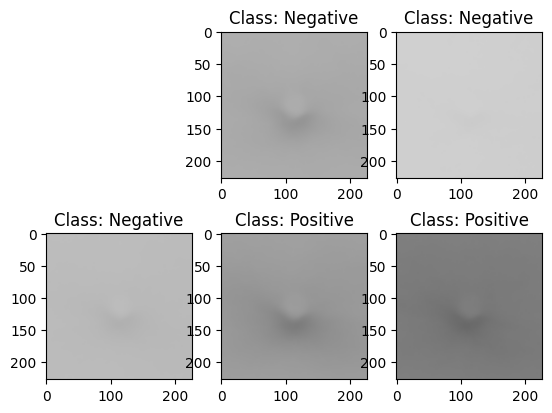

In [81]:
# Convert the images back to their original shapes for visualization 
centers = centers.reshape(5,227,227)

visualizeCenters(class_values, centers)